In [3]:
# 设置工作路径
import os
os.chdir("C:\\Users\\Zhu\\Python\\在线网络计算器")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径:", current_path)

当前工作路径: C:\Users\Zhu\Python\在线网络计算器


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('dataset.csv')
# 划分特征和目标变量
X = df.drop(['group'], axis=1)
y = df['group']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,                                                     
                                                    random_state=42, stratify=df['group'])
df.head()

,Age,Tumor_Size,Distant_lymph,T,N,Brain_metastasis,lung_metastasis,Radiotherapy,Chemotherapy,group
0,0,65,0,1,0,0,0,0,0,0
1,1,70,0,1,0,0,0,1,0,0
2,0,17,0,1,0,0,0,0,0,0
3,0,120,0,1,0,0,0,0,1,0
4,1,25,0,1,0,0,0,0,0,0


In [5]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {    
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1    
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）    
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务    
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合    
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息    
    'seed': 42,                       # 随机种子，用于重现模型的结果    
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心    
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力    
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力    
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
}

# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)

# 定义参数网格，用于网格搜索
param_grid = {    
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量    
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度    
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率
}

# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(    
    estimator=model_xgb,    
    param_grid=param_grid,    
    scoring='neg_log_loss',  # 评价指标为负对数损失    
    cv=5,                    # 5折交叉验证    
    n_jobs=-1,               # 并行计算    
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400}
Best Log Loss score:  0.3301891708181825


In [6]:
from sklearn.metrics import classification_report
# 预测测试集
y_pred = best_model.predict(X_test)
# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       484
           1       0.82      0.89      0.85       484

    accuracy                           0.85       968
   macro avg       0.85      0.85      0.85       968
weighted avg       0.85      0.85      0.85       968



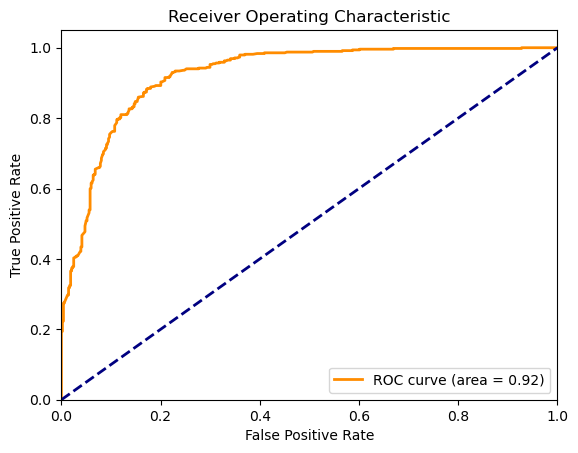

In [7]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
import joblib
# 保存模型
joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']

In [9]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Load the model
model = joblib.load('XGBoost.pkl')

# Define feature options
T_options = {    
    0: 'I (0)',    
    1: 'II (1)',    
    2: 'III (2)',    
    3: 'IV (3)'
}


# Define feature names
feature_names = [    
    "Age", "Tumor size", "Distant lymph node metastasis", "EOD T", "EOD N",    
    "Brain metastasis", "Lung metastasis", "Radiotherapy", "Chemotherapy"
]

# Streamlit user interface
st.title("Predicted risk of bone metastasis from hepatocellular carcinoma")

# age: categorical selection
Age = st.selectbox("Age (0=<60, 1=>60):", options=[0, 1], format_func=lambda x: '<60 (0)' if x == 0 else '>60 (1)')

# Tumor_Size: numerical input
Tumor_Size = st.number_input("Tumor size:", min_value=2, max_value=280, value=50)

# Distant_lymph: categorical selection
Distant_lymph = st.selectbox("Distant lymph node metastasis (0=No, 1=Yes):", options=[0, 1], format_func=lambda x: 'No (0)' if x == 0 else 'Yes (1)')

# T: categorical selection
T = st.selectbox("EOD T:", options=list(T_options.keys()), format_func=lambda x: T_options[x])

# N: categorical selection
N = st.selectbox("EOD N (0=N0, 1=N1):", options=[0, 1], format_func=lambda x: 'N0 (0)' if x == 0 else 'N1 (1)')

# Brain_metastasis: categorical selection
Brain_metastasis = st.selectbox("Brain metastasis (0=No, 1=Yes):", options=[0, 1], format_func=lambda x: 'No (0)' if x == 0 else 'Yes (1)')

# lung_metastasis: categorical selection
lung_metastasis = st.selectbox("lung metastasis (0=No, 1=Yes):", options=[0, 1], format_func=lambda x: 'No (0)' if x == 0 else 'Yes (1)')

# Radiotherapy: categorical selection
Radiotherapy = st.selectbox("Radiotherapy (0=No, 1=Yes):", options=[0, 1], format_func=lambda x: 'No (0)' if x == 0 else 'Yes (1)')

# Chemotherapy: categorical selection
Chemotherapy = st.selectbox("Chemotherapy (0=No, 1=Yes):", options=[0, 1], format_func=lambda x: 'No (0)' if x == 0 else 'Yes (1)')


# Process inputs and make predictions
feature_values = [Age, Tumor_Size, Distant_lymph, T, N, Brain_metastasis, lung_metastasis, Radiotherapy, Chemotherapy]
features = np.array([feature_values])

if st.button("Predict"):    
    # Predict class and probabilities    
    predicted_class = model.predict(features)[0]    
    predicted_proba = model.predict_proba(features)[0]
    
    # Display prediction results    
    st.write(f"**Predicted Class:** {predicted_class}")    
    st.write(f"**Prediction Probabilities:** {predicted_proba}")
    
    # Generate advice based on prediction results    
    probability = predicted_proba[predicted_class] * 100
    
    if predicted_class == 1:        
        advice = (            
            f"Our model indicates that you have a high risk of bone metastasis from hepatocellular carcinoma. "
            f"The predicted probability of developing bone metastasis is {probability:.1f}%. "
            "While this is an estimate, it suggests that you may be at significant risk. "
            "I recommend consulting an oncologist as soon as possible for further evaluation, "
            "to ensure accurate diagnosis and appropriate treatment."       
        )    
    else:        
         advice = (            
            f"Our model indicates that you have a low risk of bone metastasis from hepatocellular carcinoma. "
            f"The predicted probability of not having bone metastasis is {probability:.1f}%. "
            "However, maintaining a healthy lifestyle remains essential. "
            "I recommend regular check-ups to monitor your health, "
            "and to seek medical advice promptly if you experience any symptoms."
        )
    st.write(advice)

    # Calculate SHAP values and display force plot    
    explainer = shap.TreeExplainer(model)    
    shap_values = explainer.shap_values(pd.DataFrame([feature_values], columns=feature_names))

    shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame([feature_values], columns=feature_names), matplotlib=True)    
    plt.savefig("shap_force_plot.png", bbox_inches='tight', dpi=1200) 

    st.image("shap_force_plot.png")

2024-10-31 17:10:28.799 
  command:

    streamlit run C:\Users\Zhu\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
